학교급과 학년(초등학교 3~6학년, 중학교 1~5학년, 고등학교 1학년)을 예측하는 모델

- 학습목표
    - 한국어 텍스트 데이터 전처리, 특징 추출(WorldCloud)
    - 텍스트 백터화
    - 하이퍼파라미터 튜닝
- 데이터 출처
    - AI Hub - 수학 교과 문제 풀이과정 데이터

- 데이터셋에서 사용할 컬럼
    - school : 학교급 (초중고)
    - grade : 학년(3~6,1~3,1)
    - text_description : 수학 문제의 텍스트 설명
- target(class)
    - 총 8개의 클래스
        - 초등학교 3~6학년, 중학교 1~3학년, 고등학교 1학년

- 목차
    - 라이브러리 설정 및 데이터 불러오기
    - 탐색적 데이터 분석 (EDA)
    - 텍스트 데이터 전처리
    - 특징 추출 및 백터화
    - 모델 구현 및 학습
    - 모델 성능 평가 및 해석
    - 하이퍼파리미터 튜닝

## 1. 라이브러리 설정 및 데이터 불러오기

In [191]:
# 기본 라이브러리
import pandas as pd
import numpy as np

# 시각화
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
mpl.rcParams['font.family'] = 'NanumGothic'

# 텍스트 전처리
import re                               # 텍스트 패턴 처리 (정규표현식)
from collections import Counter         # 단어 출현 빈도수 세는 용도

# 텍스트 파싱 및 머신러닝 라이브러리
from bs4 import BeautifulSoup           # HTML 태그 등 텍스트 전처리용
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score     # 데이터분할, 하이퍼파라미터 최적화, 
from sklearn.preprocessing import LabelEncoder # 레이블(문자+숫자)인코딩

# 머신러닝 라이브러리
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB   # 다항분포 나이브베이즈 모델 
from sklearn.metrics import(
    accuracy_score,                 # 정확도
    precision_score,                # 정밀도
    recall_score,                   # 재현율
    f1_score,                 # F1 스코어
    classification_report,          # 분류 평가 보고서
    confusion_matrix                # 혼동행렬 지표
    
)


# 경고메시지 숨김용
import warnings
warnings.filterwarnings('ignore')
print('라이브러리 임포트 완료')

라이브러리 임포트 완료


In [192]:
train_df = pd.read_csv("data/school_train.csv")
train_df.head()

,school,grade,text_descriptions
0,초등학교,3학년,계산 결과가 3000보다 큰 곱셈식을 모두 선택하세요.\n첫 번째 집: $80 \t...
1,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지 찾아 선택하세요.\n$3\times4$ $30...
2,초등학교,3학년,$\square$ 안의 수가 다른 하나를 찾아 기호를 선택해보세요.\n㉠ $60 \...
3,초등학교,3학년,계산 결과가 큰 것부터 순서대로 나열한 것을 고르세요.\n$4 \times 28$\...
4,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지를 찾아 선택하세요.\n\[ \begin{arr...


In [193]:
test_df = pd.read_csv("data/school_test.csv")
test_df.head()

,school,grade,text_descriptions
0,초등학교,3학년,가방 $80$개를 $4$개의 상자에 똑같이 나누어 담았습니다. 상자 한 개에 담은 ...
1,초등학교,3학년,학생 $120$명이 체육대회에 참여했습니다. $600$개의 장난감을 학생들에게 똑같...
2,초등학교,3학년,사탕 225개를 15개의 박스에 똑같이 나누어 담았습니다. 박스 한 개에 담은 사탕...
3,초등학교,3학년,도서관에 책 $270$권이 있습니다. 이 책을 $9$개의 책꽂이에 똑같이 나누어 놓...
4,초등학교,3학년,기차 8대에 320명의 승객이 탑승했습니다. 기차 한 대에 탑승한 승객은 몇 명일까요?


In [194]:
print(f"학습 데이터: {train_df.shape[0]}개 데이터, {train_df.shape[1]}개 컬럼")
print(f"테스트 데이터: {test_df.shape[0]}개 데이터, {test_df.shape[1]}개 컬럼")

train_df.columns.to_list()

학습 데이터: 16248개 데이터, 3개 컬럼
테스트 데이터: 2032개 데이터, 3개 컬럼


['school', 'grade', 'text_descriptions']

# 탐색적 데이터 분석 (EDA)

In [195]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16248 entries, 0 to 16247
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   school             16248 non-null  object
 1   grade              16248 non-null  object
 2   text_descriptions  16248 non-null  object
dtypes: object(3)
memory usage: 380.9+ KB


In [196]:
train_df.isna().sum()

school               0
grade                0
text_descriptions    0
dtype: int64

In [197]:
test_df.isnull().sum()

school               0
grade                0
text_descriptions    0
dtype: int64

In [198]:
# train_df.fillna()
# train_df.dropna()

# 만약 결측치가 test_descriptions 컬럼의 결측치 행을 제거하고싶다면
# train_df.dropna(subset=['text_descriptions'],inplace=True)

In [199]:
train_df['school_grade'] = train_df['school'] +' ' + train_df['grade']


[Text(0, 0, '고등\n1학년'),
 Text(1, 0, '초등\n3학년'),
 Text(2, 0, '초등\n4학년'),
 Text(3, 0, '초등\n5학년'),
 Text(4, 0, '초등\n6학년'),
 Text(5, 0, '중\n3학년'),
 Text(6, 0, '중\n1학년'),
 Text(7, 0, '중\n2학년')]

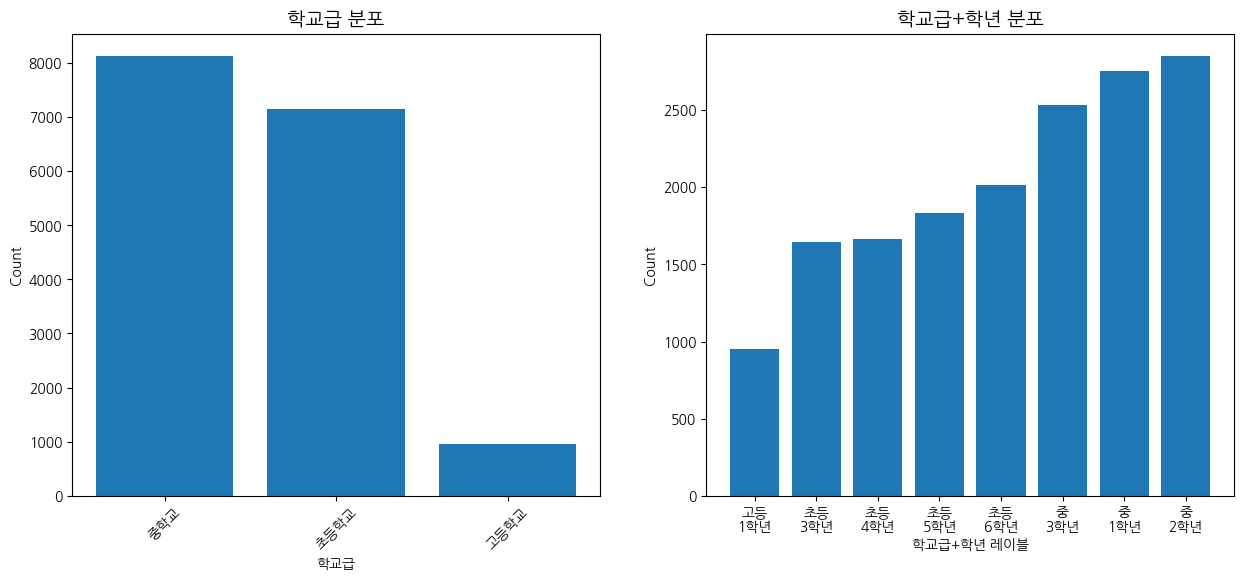

In [ ]:
# 타겟 변수 분포 시각화
fig, axes = plt.subplots(1,2,figsize=(15,6))

# 학교급 분포 (예: 초중고)
school_counts = train_df['school'].value_counts()

axes[0].bar(school_counts.index, school_counts.values)      # 막대 그래프
axes[0].set_title("학교급 분포", fontsize=14)
axes[0].set_xlabel('학교급')
axes[0].set_ylabel('Count')
axes[0].tick_params(axis='x',rotation=45)   # x축 라벨 설정

# 학교급-학년 조합 분포 (예: 초3, 중2, 고1)

school_grade_counts = train_df['school_grade'].value_counts().sort_values()

axes[1].bar(school_grade_counts.index, school_grade_counts.values)      # 막대 그래프
axes[1].set_title("학교급+학년 분포", fontsize=14)
axes[1].set_xlabel('학교급+학년 레이블')
axes[1].set_ylabel('Count')
axes[1].set_xticks(range(len(school_grade_counts))) # x축 눈금 설정
axes[1].set_xticklabels([sg.replace('학교','').replace(' ','\n') for sg in school_grade_counts.index], rotation=0)


고등학교 문제를 잘 못 맞출

In [234]:
# 클래스 불균형 분석

class_ratio = school_grade_counts / school_grade_counts.sum() * 100 # 각 클래스가 전체에서 차지하는 비율 계산 
for class_name, ratio, in class_ratio.items():
    print(f"{class_name} : {ratio:.2f}%")

imbalance_ratio = school_grade_counts.max() / school_grade_counts.min()
print(f"최대/최소 클래스 비율 : {imbalance_ratio:.2f}")


고등학교 1학년 : 5.86%
초등학교 3학년 : 10.14%
초등학교 4학년 : 10.25%
초등학교 5학년 : 11.27%
초등학교 6학년 : 12.40%
중학교 3학년 : 15.58%
중학교 1학년 : 16.95%
중학교 2학년 : 17.57%
최대/최소 클래스 비율 : 3.00


고등학교 문제가 적다!

텍스트 데이터 분석

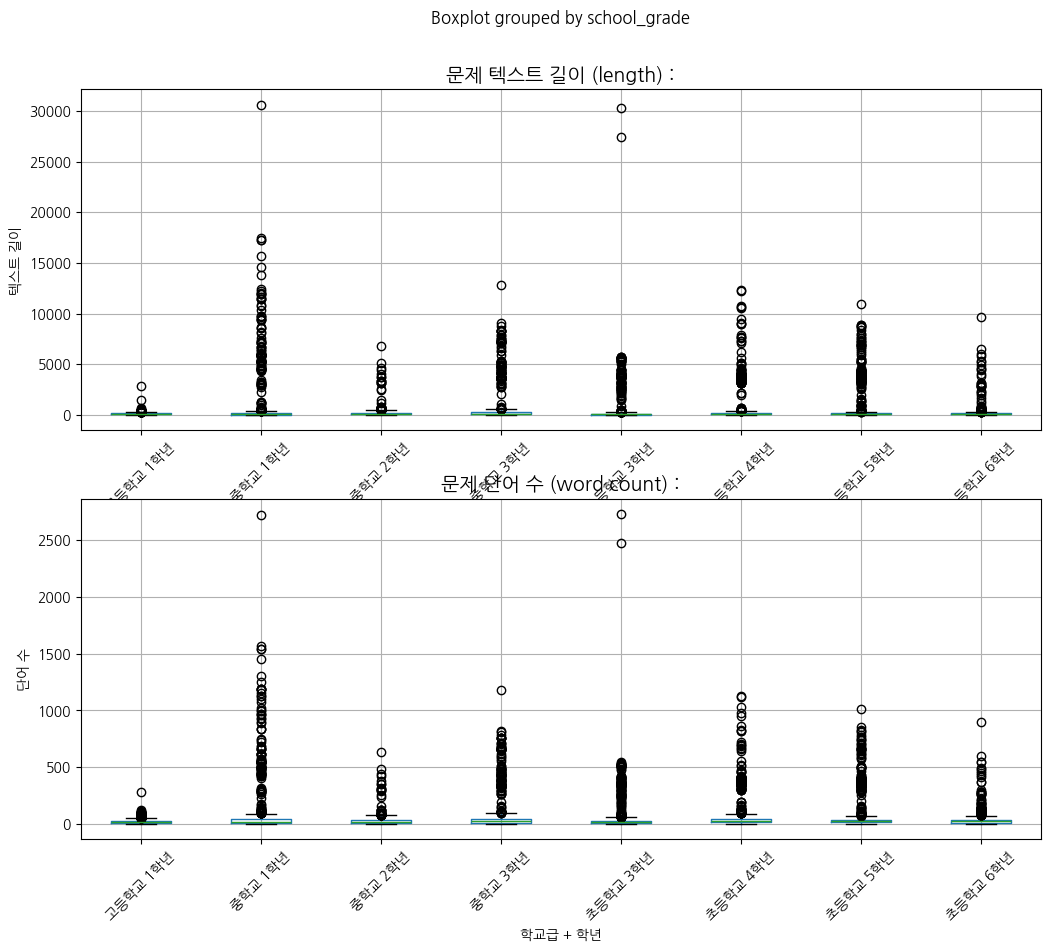

In [202]:
# 텍스트 길이 및 단어 수 분석
train_df['text_length'] = train_df['text_descriptions'].str.len()   # 텍스트(문제) 글자 수
train_df['word_count'] = train_df['text_descriptions'].str.split().str.len()   # 텍스트(문제) 글자내 단어  수

# 학교급별 텍스트 길이 분포
fig, axes = plt.subplots(2,1,figsize=(12,10))
train_df.boxplot(column='text_length', by='school_grade', ax=axes[0])
axes[0].set_title('문제 텍스트 길이 (length) :', fontsize=14)
axes[0].set_xlabel("학교급 + 학년")
axes[0].set_ylabel("텍스트 길이")
axes[0].tick_params(axis='x',rotation=45)

# 단어 수 박스플롯
train_df.boxplot(column='word_count', by='school_grade', ax=axes[1])
axes[1].set_title('문제 단어 수 (word count) :', fontsize=14)
axes[1].set_xlabel("학교급 + 학년")
axes[1].set_ylabel("단어 수")
axes[1].tick_params(axis='x',rotation=45)

텍스트 기준 1000자, 단어 수 200개 글자 정도안에 들어와야 정상일 것으로 보인다. 이상치 처리가 필요하다.

In [203]:
train_df[train_df['text_length']>=1000]['text_descriptions'].iloc[0]

'지름을 나타내는 선분을 찾아 길이를 잰 값을 보고, 맞는 말을 선택해 보 세요.\n한 원에서 원의 지름은 모두 (같습니다, 다릅니다).\n정원형이 있고 중심에는 ㅇ 가 있습니다. 점 ㅇ와 연결된 꼭짓점 (ㄷ, ㅅ, ㄴ, ㄷ, ㄹ, ㅁ, ㅂ)가 있습니다.\n<div class="table_tabular " style="text-align: center"> <div class="inline-tabular"><table id="tabular"> <tbody> <tr style="border-top: none !important; border-bottom: none !important;"> <td style="text-align: center; border-left: none !important; border-right-style: solid !important; border-right-width: 1px !important; border-bottom-style: solid !important; border-bottom-width: 1px !important; border-top-style: solid !important; border-top-width: 1px !important; width: auto; vertical-align: middle; ">지름</td> <td style="text-align: center; border-right-style: solid !important; border-right-width: 1px !important; border-bottom-style: solid !important; border-bottom-width: 1px !important; border-top-style: solid !important; border-top-width: 1px !important; width: auto; vertical-align: middle; ">선분 ㄱㅁ</td> <td style="text-align: center; border-ri

html 태그가 들어있다. 삭제가 필요한 부분이라 판단된다.

In [204]:
def remove_html_tags(text):
    return BeautifulSoup(text,'html.parser').get_text()

train_df['text_descriptions_clean'] = train_df['text_descriptions'].apply(remove_html_tags)

train_df[train_df['text_length']>=1000]['text_descriptions_clean'].iloc[0]

'지름을 나타내는 선분을 찾아 길이를 잰 값을 보고, 맞는 말을 선택해 보 세요.\n한 원에서 원의 지름은 모두 (같습니다, 다릅니다).\n정원형이 있고 중심에는 ㅇ 가 있습니다. 점 ㅇ와 연결된 꼭짓점 (ㄷ, ㅅ, ㄴ, ㄷ, ㄹ, ㅁ, ㅂ)가 있습니다.\n    지름 선분 ㄱㅁ 선분 ㄴㅂ 선분 ㄹㅅ   길이  $(\\mathrm{cm})$ 3 3 3    '

In [205]:
train_df['text_descriptions'] = train_df['text_descriptions_clean']
train_df.drop(columns=['text_descriptions_clean'],inplace=True)

In [206]:
train_df

,school,grade,text_descriptions,school_grade,text_length,word_count
0,초등학교,3학년,계산 결과가 3000보다 큰 곱셈식을 모두 선택하세요.\n첫 번째 집: $80 \t...,초등학교 3학년,122,31
1,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지 찾아 선택하세요.\n$3\times4$ $30...,초등학교 3학년,101,21
2,초등학교,3학년,$\square$ 안의 수가 다른 하나를 찾아 기호를 선택해보세요.\n㉠ $60 \...,초등학교 3학년,130,26
3,초등학교,3학년,계산 결과가 큰 것부터 순서대로 나열한 것을 고르세요.\n$4 \times 28$\...,초등학교 3학년,72,17
4,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지를 찾아 선택하세요.\n\[ \begin{arr...,초등학교 3학년,248,50
...,...,...,...,...,...,...
16243,고등학교,1학년,유리함수 $y=\frac{x+a}{b x+c}$의 그래프가 오른쪽 그림과 같고이 그...,고등학교 1학년,272,56
16244,고등학교,1학년,유리함수 $y=\frac{k x}{x+3}$의 그래프가 직선 $y=x$에 대하여 대...,고등학교 1학년,68,13
16245,고등학교,1학년,분모를 0으로 하지 않는 모든 실수 $x$에 대하여 등식 \[ \begin{arra...,고등학교 1학년,210,28
16246,고등학교,1학년,오른쪽 그림과 같이 유리 함수 $y=\frac{9}{x}+2(x>0)$의 그래프 위...,고등학교 1학년,271,38


In [266]:
train_df['text_length'] = train_df['text_descriptions'].str.len()   # 텍스트(문제) 글자 수
train_df['word_count'] = train_df['text_descriptions'].str.split().str.len()   # 텍스트(문제) 글자내 단어  수
train_df[train_df['text_length']>=1000]['text_descriptions']

text = train_df.loc[16038, 'text_descriptions']
from IPython.display import display, Markdown

display(Markdown(text))

다음 그림과 같이 $x$ 축 위의 네 점 $\mathrm{A}_{1}, \mathrm{~A}_{2}, \mathrm{~A}_{3}, \mathrm{~A}_{4}$에 대하여 $\overline{\mathrm{OA}_{1}}, \overline{\mathrm{~A}_{1} \mathrm{~A}_{2}}, \overline{\mathrm{~A}_{2} \mathrm{~A}_{3}}, \overline{\mathrm{~A}_{3} \mathrm{~A}_{4}}$를 각각 한 변으로 하는 정사각형 $\mathrm{OA}_{1} \mathrm{~B}_{1} \mathrm{C}_{1}, \mathrm{~A}_{1} \mathrm{~A}_{2} \mathrm{~B}_{2} \mathrm{C}_{2}, \mathrm{~A}_{2} \mathrm{~A}_{3} \mathrm{~B}_{3} \mathrm{C}_{3}$, $\mathrm{A}_{3} \mathrm{~A}_{4} \mathrm{~B}_{4} \mathrm{C}_{4}$가 있다. 점 $\mathrm{B}_{4}$의 좌표가 $(30, 18)$ 이고 정사각형 $\mathrm{OA}_{1} \mathrm{~B}_{1} \mathrm{C}_{1}, \mathrm{~A}_{1} \mathrm{~A}_{2} \mathrm{~B}_{2} \mathrm{C}_{2}, \mathrm{~A}_{2} \mathrm{~A}_{3} \mathrm{~B}_{3} \mathrm{C}_{3}$의 넓이의 비가 $1: 4: 9$ 일 때, ${\overline{\mathrm{B}_{1} \mathrm{~B}_{3}}}^{2}$의 값을 구하시오. (단, O는 원점이다.)
좌표 평면에 $x$축 위의 네 점 $\mathrm{A}_{1}, \mathrm{~A}_{2}, \mathrm{~A}_{3}, \mathrm{~A}_{4}$에 대하여 $\overline{\mathrm{OA}_{1}}, \overline{\mathrm{~A}_{1} \mathrm{~A}_{2}}, \overline{\mathrm{~A}_{2} \mathrm{~A}_{3}}, \overline{\mathrm{~A}_{3} \mathrm{~A}_{4}}$를 각각 한 변으로 하는 정사각형 $\mathrm{OA}_{1} \mathrm{~B}_{1} \mathrm{C}_{1}, \mathrm{~A}_{1} \mathrm{~A}_{2} \mathrm{~B}_{2} \mathrm{C}_{2}, \mathrm{~A}_{2} \mathrm{~A}_{3} \mathrm{~B}_{3} \mathrm{C}_{3}$, $\mathrm{A}_{3} \mathrm{~A}_{4} \mathrm{~B}_{4} \mathrm{C}_{4}$가 있다. 점 $\mathrm{B}_{4}$의 좌표가 $(30, 18)$ 이고, $O$점은 원점이며, y축과 x축이 각각 위와 오른쪽으로 향해 있다.

In [267]:
test_df['text_descriptions_clean'] = test_df['text_descriptions'].apply(remove_html_tags)
test_df['text_descriptions'] = test_df['text_descriptions_clean']
test_df.drop(columns=['text_descriptions_clean'],inplace=True)
test_df

,school,grade,text_descriptions,school_grade,target
0,초등학교,3학년,가방 $80$개를 $4$개의 상자에 똑같이 나누어 담았습니다. 상자 한 개에 담은 ...,초등학교 3학년,4
1,초등학교,3학년,학생 $120$명이 체육대회에 참여했습니다. $600$개의 장난감을 학생들에게 똑같...,초등학교 3학년,4
2,초등학교,3학년,사탕 225개를 15개의 박스에 똑같이 나누어 담았습니다. 박스 한 개에 담은 사탕...,초등학교 3학년,4
3,초등학교,3학년,도서관에 책 $270$권이 있습니다. 이 책을 $9$개의 책꽂이에 똑같이 나누어 놓...,초등학교 3학년,4
4,초등학교,3학년,기차 8대에 320명의 승객이 탑승했습니다. 기차 한 대에 탑승한 승객은 몇 명일까요?,초등학교 3학년,4
...,...,...,...,...,...
2027,고등학교,1학년,6명의 학생을 다음과 같이 3개의 조로 나누는 모든 방법의 수를 구하시오.\n① 1...,고등학교 1학년,0
2028,고등학교,1학년,"A, B, C, A의 네 지점이 오른쪽 그림과 같이 서로 여러 개의 길로 연결되어 ...",고등학교 1학년,0
2029,고등학교,1학년,"오른쪽 그림과 같이 평행한 두 직선 $l$, $m$ 위에 점이 각각 $3$개, $4...",고등학교 1학년,0
2030,고등학교,1학년,"오른쪽 그림과 같이 삼각형 위에 서로 다른 9개의 점 $\mathrm{A}_{1},...",고등학교 1학년,0


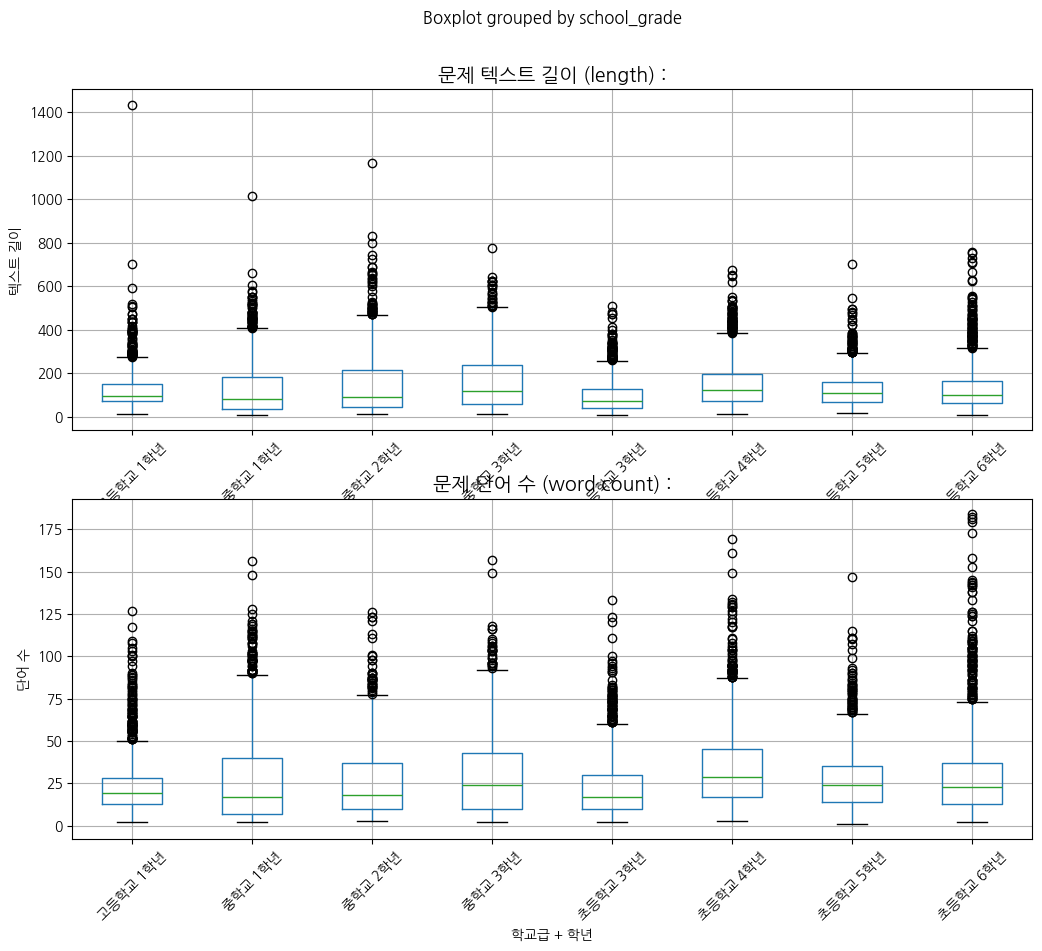

In [268]:
# 텍스트 길이 및 단어 수 분석
train_df['text_length'] = train_df['text_descriptions'].str.len()               # 텍스트(문제) 글자 수
train_df['word_count'] = train_df['text_descriptions'].str.split().str.len()    # 텍스트(문제) 글자내 단어  수

# 학교급별 텍스트 길이 분포
fig, axes = plt.subplots(2,1,figsize=(12,10))
train_df.boxplot(column='text_length', by='school_grade', ax=axes[0])
axes[0].set_title('문제 텍스트 길이 (length) :', fontsize=14)
axes[0].set_xlabel("학교급 + 학년")
axes[0].set_ylabel("텍스트 길이")
axes[0].tick_params(axis='x',rotation=45)

# 단어 수 박스플롯
train_df.boxplot(column='word_count', by='school_grade', ax=axes[1])
axes[1].set_title('문제 단어 수 (word count) :', fontsize=14)
axes[1].set_xlabel("학교급 + 학년")
axes[1].set_ylabel("단어 수")
axes[1].tick_params(axis='x',rotation=45)

학년이 올라갈수록 길이가 길어진다. 하지만 고등학교는 표본수가 적어서 구별하기가 애매할 수 있다.

In [269]:
# 학년별 텍스트 길이 및 단어 수의 평균, 표준편차 집계
text_stats = train_df.groupby('school_grade')[['text_length','word_count']].agg(['mean','std'])
print(text_stats.round(2))

             text_length         word_count       
                    mean     std       mean    std
school_grade                                      
고등학교 1학년          126.61   97.75      24.32  19.22
중학교 1학년           122.35  109.35      26.00  23.96
중학교 2학년           140.89  124.45      24.80  18.71
중학교 3학년           155.97  121.82      28.47  21.59
초등학교 3학년           95.26   74.83      22.63  18.22
초등학교 4학년          150.23  104.93      34.43  23.83
초등학교 5학년          121.03   76.15      27.02  17.54
초등학교 6학년          125.24   96.21      29.02  23.82


학교급과 학년별로는 글자수와 문장수로 판단이 될만한 요소는 있지만, 고등학교가 애매하다.
그래서 특징으로 자주 나오는 단어등을 같이 추가를 해줘야 정확한 겨과를 얻을 수 있을 것으로 판단이 된다.

In [210]:
# 학년별 특징적인 단어 추출 (상위 10개)
for grade in train_df['school_grade'].unique():
    grade_texts = " ".join(train_df[train_df['school_grade'] == grade]['text_descriptions'].tolist())


    # 한글 단어만 추출
    words = re.findall(r"[가-힣]+",grade_texts)
    word_counts = Counter(words)

    # 조사삭제
    stopwords = ['의','를','을','과','에','는','이','가','하고','에서','으로','로','와']
    for sw in stopwords:
        word_counts.pop(sw, None)
        
    print(grade)
    for word, count in word_counts.most_common(10): # 상위 10개 단어
        print(f"{word} {count}회")
    

초등학교 3학년
있습니다 461회
선택하세요 453회
모두 311회
수 299회
있다 298회
두 291회
것을 271회
큰 269회
몇 245회
가장 238회
초등학교 4학년
있습니다 882회
선택하세요 754회
있다 473회
것을 461회
수 450회
두 397회
나타낸 397회
있는 340회
알맞은 328회
찾아 315회
초등학교 5학년
보세요 961회
있다 542회
것을 482회
찾아 443회
선택하세요 400회
수 394회
선택해 359회
있습니다 348회
모두 328회
두 324회
초등학교 6학년
보세요 1207회
있습니다 771회
개 629회
있다 499회
선택해 496회
본 445회
모양을 430회
개의 415회
찾아 405회
인 385회
중학교 1학년
다음 1139회
오른쪽 908회
때 851회
구하시오 643회
있다 626회
있습니다 597회
두 590회
점 553회
중 513회
계산하시오 484회
중학교 2학년
때 1422회
다음 1237회
점 1065회
오른쪽 970회
구하시오 883회
일 866회
삼각형 667회
길이는 652회
있습니다 651회
그림과 604회
중학교 3학년
점 1346회
때 1168회
오른쪽 1099회
있습니다 1076회
다음 836회
일 785회
원 736회
길이는 692회
각 632회
있다 568회
고등학교 1학년
때 530회
구하시오 477회
두 325회
대하여 306회
값을 300회
점 293회
다음 244회
일 199회
실수 148회
집합 140회


In [270]:
test_df['school_grade'] = test_df['school']+' '+test_df['grade']


In [271]:
test_df

,school,grade,text_descriptions,school_grade,target
0,초등학교,3학년,가방 $80$개를 $4$개의 상자에 똑같이 나누어 담았습니다. 상자 한 개에 담은 ...,초등학교 3학년,4
1,초등학교,3학년,학생 $120$명이 체육대회에 참여했습니다. $600$개의 장난감을 학생들에게 똑같...,초등학교 3학년,4
2,초등학교,3학년,사탕 225개를 15개의 박스에 똑같이 나누어 담았습니다. 박스 한 개에 담은 사탕...,초등학교 3학년,4
3,초등학교,3학년,도서관에 책 $270$권이 있습니다. 이 책을 $9$개의 책꽂이에 똑같이 나누어 놓...,초등학교 3학년,4
4,초등학교,3학년,기차 8대에 320명의 승객이 탑승했습니다. 기차 한 대에 탑승한 승객은 몇 명일까요?,초등학교 3학년,4
...,...,...,...,...,...
2027,고등학교,1학년,6명의 학생을 다음과 같이 3개의 조로 나누는 모든 방법의 수를 구하시오.\n① 1...,고등학교 1학년,0
2028,고등학교,1학년,"A, B, C, A의 네 지점이 오른쪽 그림과 같이 서로 여러 개의 길로 연결되어 ...",고등학교 1학년,0
2029,고등학교,1학년,"오른쪽 그림과 같이 평행한 두 직선 $l$, $m$ 위에 점이 각각 $3$개, $4...",고등학교 1학년,0
2030,고등학교,1학년,"오른쪽 그림과 같이 삼각형 위에 서로 다른 9개의 점 $\mathrm{A}_{1},...",고등학교 1학년,0


In [272]:
target_classes = sorted(train_df['school_grade'].unique())  # 타겟 클래스 목록(오름차순 정렬)
for i, tc in enumerate(target_classes):
    print(f"{i}: {tc}")     # 클래스 번호와 클래스명 출력


0: 고등학교 1학년
1: 중학교 1학년
2: 중학교 2학년
3: 중학교 3학년
4: 초등학교 3학년
5: 초등학교 4학년
6: 초등학교 5학년
7: 초등학교 6학년



- 레이블 인코딩
    - 문자형 범주형 변수를 숫자로 변환
    

In [274]:
# school_grade를 숫자형 타겟으로 변환
label_encoder = LabelEncoder()
train_df['target'] = label_encoder.fit_transform(train_df['school_grade'])      # 학습 데이터 인코딩
test_df['target'] = label_encoder.transform(test_df['school_grade'])            # 테스트 데이터 인코딩

train_df

,school,grade,text_descriptions,school_grade,text_length,word_count,target
0,초등학교,3학년,계산 결과가 3000보다 큰 곱셈식을 모두 선택하세요.\n첫 번째 집: $80 \t...,초등학교 3학년,122,31,4
1,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지 찾아 선택하세요.\n$3\times4$ $30...,초등학교 3학년,101,21,4
2,초등학교,3학년,$\square$ 안의 수가 다른 하나를 찾아 기호를 선택해보세요.\n㉠ $60 \...,초등학교 3학년,130,26,4
3,초등학교,3학년,계산 결과가 큰 것부터 순서대로 나열한 것을 고르세요.\n$4 \times 28$\...,초등학교 3학년,72,17,4
4,초등학교,3학년,색칠된 부분은 실제 어떤 수의 곱인지를 찾아 선택하세요.\n\[ \begin{arr...,초등학교 3학년,248,50,4
...,...,...,...,...,...,...,...
16243,고등학교,1학년,유리함수 $y=\frac{x+a}{b x+c}$의 그래프가 오른쪽 그림과 같고이 그...,고등학교 1학년,272,56,0
16244,고등학교,1학년,유리함수 $y=\frac{k x}{x+3}$의 그래프가 직선 $y=x$에 대하여 대...,고등학교 1학년,68,13,0
16245,고등학교,1학년,분모를 0으로 하지 않는 모든 실수 $x$에 대하여 등식 \[ \begin{arra...,고등학교 1학년,210,28,0
16246,고등학교,1학년,오른쪽 그림과 같이 유리 함수 $y=\frac{9}{x}+2(x>0)$의 그래프 위...,고등학교 1학년,271,38,0


### 4. 특징 추출 및 백터화
- TF-ITF : 얼마나 자주 단어가 나오느냐
    - 하나의 문서에서 단어의 중요도를 빈도수(TF - TERM FREQUENCY)로 표현한다. - 전체 문서에서의 희귀도 (IDF - Inverse Document Frequency) 를 결합해서 측정하는 방식


In [275]:
tfidft_vectorizer = TfidfVectorizer(
    max_features = 1000,            # 최대 feature 수 : 추출할 최대 단어 수
    min_df = 2,                     # 최소 문서 빈도 : 최소 2개 문서에는 등장해야 feature 로 사용
    max_df = 0.8,                   # 최대 문서 빈도 : 전체 문서 중 80% 이하에서 등장하는 단어만 사용
    ngram_range = (1,3),            # 1~3단어 조합까지 백터화 (unigram, bigram, trigram)
    sublinear_tf = True,            # tf 값에 log 적용 : 빈도수에 log 스케일 적용
    use_idf = True                  # IDF 사용
)
# 학습 데이터로 벡터라이저 학습 및 변환 (문자->백터)
X_train_tfidf = tfidft_vectorizer.fit_transform(train_df['text_descriptions'])
# 테스트 데이터로 벡터라이저 학습데이터와 동일한 기준으로 변환 (문자->백터)
X_test_tfidf = tfidft_vectorizer.transform(test_df['text_descriptions'])

print(X_train_tfidf.shape)
print(X_test_tfidf.shape)



(16248, 1000)
(2032, 1000)


- CountVectorizer
    - 텍스트 데이터를 숫자 백터로 변환할때 가장 기본적인 방식.
    - 각 문서에 어떤 단어가 몇번 등장했는지 세어주는 도구
    

In [276]:
count_vectorizer = CountVectorizer(
    max_features=1000,
    min_df=2,
    max_df=0.8,
    ngram_range=(1,3)    
)

# 학습 데이터로 CountVectorizer 학습 및 변환 (문자->백터)
X_train_count = count_vectorizer.fit_transform(train_df['text_descriptions'])
# 테스트 데이터로 CountVectorizer 학습데이터와 동일한 기준으로 변환 (문자->백터)
X_test_count = count_vectorizer.transform(test_df['text_descriptions'])

print(X_train_count.shape)
print(X_test_count.shape)



(16248, 1000)
(2032, 1000)


- 추가 특징 생성
    - 텍스트 길이
    - 수학 기호, 숫자 관련 특징
    - 특정 키워드 포함 여부
    - 괄호 사용

In [278]:
# 추가 특징 생성 함수
def extract_addtional_features(df):
    features = pd.DataFrame()
    
    # 텍스트 길이, 단어 수, 평균 단어 길이
    features['text_length'] = df['text_descriptions'].str.len()                                     # 전체 글자 수
    features['word_count'] = df['text_descriptions'].str.split().str.len()                          # 전체 단어 수
    features['avg_word_length'] = features['text_length'] / (features['word_count']+1)              # 평균 단어 길이
    
    # 수학 기호, 숫자 관련 특징 패턴 추출
    features['num_count'] = df['text_descriptions'].str.count(r'\d+').astype(int)                   # 숫자 등장 횟수
    features['has_fraction'] = df['text_descriptions'].str.contains(r'\d+/\d+').astype(int)         # 숫자 / 숫자 형식
    features['has_decimal'] = df['text_descriptions'].str.contains(r'\d+\.\d+').astype(int)         # 소수 포함 여부
    features['has_symbol_count'] = df['text_descriptions'].str.contains(r'[+\-×÷=]').astype(int)    # 소수 포함 여부
    
    # 특정 키워드 포함 여부
    features['has_geometry'] = df['text_descriptions'].str.contains(r'도형|삼각형|사각형|원|직사각형|정사각형').astype(int)       # 도형 포함 여부
    features['has_measurement'] = df['text_descriptions'].str.contains(r'길이|넓이|부피|무게|시간').astype(int)                  # 단위 포함 여부
    features['has_calculation'] = df['text_descriptions'].str.contains(r'계산|구하|얼마').astype(int)                           # 계산 포함 여부
    features['has_comparison'] = df['text_descriptions'].str.contains(r'크다|작다|같다|많다|적다').astype(int)                   # 비교 포함 여부
    
    # 문장 구조 관련 특징
    features['senetence_count'] = df['text_descriptions'].str.contains(r'[.!?]').astype(int)            # 문장 수 갯수(구분기호 수 +1)
    features['question_count'] = df['text_descriptions'].str.contains(r'[\?]').astype(int)              # 질문 문장 수(물음표 갯수 +1)
    
    # 괄호 사용
    features['parenthesis_count'] = df['text_descriptions'].str.contains(r'[()\[\]]').astype(int)       # 괄호 등장 횟수
    
    return features

# 추가 특징 추출 함수 적용
train_features = extract_addtional_features(train_df)
test_features = extract_addtional_features(test_df)

# 결측값은 0으로 채움
train_features = train_features.fillna(0)
test_features = test_features.fillna(0)

print(f"추가 특징 개수: {train_features.shape[1]}")
print(f"추가 특징 컬럼: {list(train_features.columns)}")

추가 특징 개수: 14
추가 특징 컬럼: ['text_length', 'word_count', 'avg_word_length', 'num_count', 'has_fraction', 'has_decimal', 'has_symbol_count', 'has_geometry', 'has_measurement', 'has_calculation', 'has_comparison', 'senetence_count', 'question_count', 'parenthesis_count']


- 정규표현식
    - r(raw_string:) 문자 그대로
    - \:약속된 패턴 사용
    - d만 사용하는경우 : 문자
    - \d : 숫자 1개
    - \d+ : 숫자 여러개(2자리이상)
    - \w : 문자+숫자+
    - \s : 공백
    - \D : 숫자가 아닌 것

In [218]:
from scipy.sparse import hstack

X_train_combined = hstack([X_train_tfidf,train_features])
X_test_combined = hstack([X_test_tfidf,test_features])

print(f"Train Shape : {X_train_combined.shape}")
print(f"Test Shape : {X_test_combined.shape}")

Train Shape : (16248, 1014)
Test Shape : (2032, 1014)


### 5. 모델 구현 및 학습
- 기몬 모델 학습

In [219]:
y_train = train_df['target']
y_test = test_df['target']


In [220]:
models = {
    'Logistics Regression': LogisticRegression(max_iter=1000, random_state=42),
    "Random Forest" : RandomForestClassifier(n_estimators=100,random_state=42),
    "Naive Bayes": MultinomialNB()      # 다항분포 나이브베이즈
}

results = {} # 모델 학습 및 평가 결과 저장

In [ ]:
for name, model in models.items():
    print(f"{name} 학습 중입니다.")
    
    if name == 'Naive Bayes':
        # Naive Vayes는 음수를 처리할 수 없다. TF-IDF 또는 count만 사용 (1000개의 컬럼만 사용)
        model.fit(X_train_tfidf, y_train)
        train_pred = model.predict(X_train_tfidf)       # 학습 데이터 예측
        test_pred = model.predict(X_test_tfidf)         # 테스트 데이터 예측
    else: 
        # 그 외 모델들은 음수 처리 가능하기 때문에 TF-IDF변수 + 추가변수 사용가능하다. (1014개의 컬럼 사용)
        model.fit(X_train_combined, y_train)
        train_pred = model.predict(X_train_combined)       # 학습 데이터 예측
        test_pred = model.predict(X_test_combined)         # 테스트 데이터 예측
        
    
    # 성능 평가 (정확도, F1 스코어)
    train_acc = accuracy_score(y_train, train_pred)     # 학습 데이터 정확도
    test_acc = accuracy_score(y_test, test_pred)     # 테스트 데이터 정확도
    test_f1 = f1_score(y_test, test_pred, average='weighted')     # 테스트 데이터 가중 f1 스코어 (다중 클래스)
    
    results[name] = {
        'model': model,
        'train_acc' : train_acc,
        'test_acc' : test_acc,
        'test_f1' : test_f1
    }
    
    print(f'학습 정확도 : {train_acc:.4f}')
    print(f'테스트 정확도 : {test_acc:.4f}')
    print(f'테스트 F1-score : {test_f1:.4f}')

Logistics Regression 학습 중입니다.
학습 정확도 : 0.6494
테스트 정확도 : 0.5738
테스트 F1-score : 0.5615
Random Forest 학습 중입니다.
학습 정확도 : 0.9956
테스트 정확도 : 0.6895
테스트 F1-score : 0.6848
Naive Bayes 학습 중입니다.
학습 정확도 : 0.7245
테스트 정확도 : 0.6107
테스트 F1-score : 0.5967


In [222]:
results

{'Logistics Regression': {'model': LogisticRegression(max_iter=1000, random_state=42),
  'train_acc': 0.6494337764647957,
  'test_acc': 0.5738188976377953,
  'test_f1': 0.5615339254102019},
 'Random Forest': {'model': RandomForestClassifier(random_state=42),
  'train_acc': 0.995630231413097,
  'test_acc': 0.6894685039370079,
  'test_f1': 0.684823176367878},
 'Naive Bayes': {'model': MultinomialNB(),
  'train_acc': 0.7244583948793698,
  'test_acc': 0.6107283464566929,
  'test_f1': 0.5966927309710899}}

In [223]:
results['Random Forest']['test_acc']

0.6894685039370079

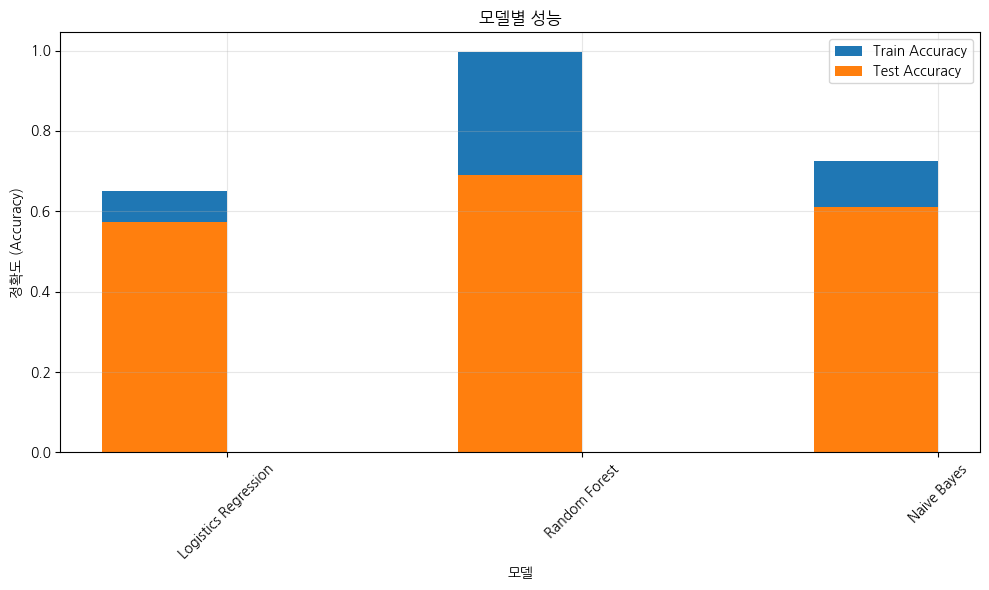

In [224]:
# 시각화
fig, ax = plt.subplots(figsize=(10,6))

model_names = list(results.keys())   # keys():딕셔너리에서 key값만 뽑아낸다.
train_accs = [results[name]['train_acc'] for name in model_names] # 학습 정확도 리스트
test_accs = [results[name]['test_acc'] for name in model_names] # 테스트 정확도 리스트

x = np.arange(len(model_names))    # x축 위치
width = 0.35

ax.bar(x-width/2, train_accs, width, label="Train Accuracy")    # 학습 정확도 막대그래프
ax.bar(x-width/2, test_accs, width, label="Test Accuracy")    # 테스트 정확도 막대그래프

ax.set_xlabel('모델')
ax.set_ylabel('정확도 (Accuracy)')
ax.set_title('모델별 성능')
ax.set_xticks(x)
ax.set_xticklabels(model_names, rotation=45)    # x축 눈금(모델명)
ax.legend()     # 범례
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### 랜덤포레스트는 성능은 가장 우수하였으나, 과적합 나머지 모델들은 과소적합

In [225]:
results

{'Logistics Regression': {'model': LogisticRegression(max_iter=1000, random_state=42),
  'train_acc': 0.6494337764647957,
  'test_acc': 0.5738188976377953,
  'test_f1': 0.5615339254102019},
 'Random Forest': {'model': RandomForestClassifier(random_state=42),
  'train_acc': 0.995630231413097,
  'test_acc': 0.6894685039370079,
  'test_f1': 0.684823176367878},
 'Naive Bayes': {'model': MultinomialNB(),
  'train_acc': 0.7244583948793698,
  'test_acc': 0.6107283464566929,
  'test_f1': 0.5966927309710899}}

In [281]:
# 가장 성능이 좋은 모델 선택
best_model_name = max(results, key=lambda x: results[x]['test_acc'])     # 테스트 정확도가 가장 높은 모델
best_model = results[best_model_name]['model']

print(f"최고 성능 모델은 {best_model_name}이다")
print(f"검증 정확도 : {results[best_model_name]['test_acc']:.4f}이다")
print(f"검증 F1-Score : {results[best_model_name]['test_f1']:.4f}이다")

# 검증 데이터에 대한 예측
if best_model_name == 'Naive Bayes':
    y_test_pred = best_model.predict(X_test_tfidf)                  # 예측 레이블
    y_test_pred_proba = best_model.predict_proba(X_test_tfidf)            # 클래스별 확률
else:
    y_test_pred = best_model.predict(X_test_combined)               # 예측 레이블
    y_test_pred_proba = best_model.predict_proba(X_test_combined)         # 클래스별 확률

# 예측 결과의 샘플 확인 (텍스트, 실제/예측 레이블, 신뢰도)
print("\n====== 예측 결과 샘플 ======")
for i in range(5):
    actual_label = label_encoder.inverse_transform([y_test.iloc[i]])[0]
    predicted_label = label_encoder.inverse_transform([y_test_pred[i]])[0]
    
    # 신뢰도(확률)까지 표시하고 싶다면
    if y_test_pred_proba is not None:
        confidence = y_test_pred_proba[i].max()
        print(f"{i}: 실제={actual_label}, 예측={predicted_label}, 신뢰도={confidence:.3f}")
    else:
        print(f"{i}: 실제={actual_label}, 예측={predicted_label}")

최고 성능 모델은 Random Forest이다
검증 정확도 : 0.6895이다
검증 F1-Score : 0.6848이다

====== 예측 결과 샘플 ======
0: 실제=초등학교 3학년, 예측=초등학교 3학년, 신뢰도=0.740
1: 실제=초등학교 3학년, 예측=초등학교 3학년, 신뢰도=0.630
2: 실제=초등학교 3학년, 예측=초등학교 3학년, 신뢰도=0.970
3: 실제=초등학교 3학년, 예측=초등학교 3학년, 신뢰도=0.880
4: 실제=초등학교 3학년, 예측=초등학교 3학년, 신뢰도=0.710
